In [1]:
from map import Map
import osmnx

from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import geopandas as gpd
import networkx

In [2]:
from collections import namedtuple

args = namedtuple('args', 'position distance type')

test_args = args(['London'], 1000, 'walk')
test_map = Map(test_args)

# test_map.draw()

/home/quizznor/Desktop/machine-learning-from-scratch/travel_flood_map/.venv/lib/python3.12/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


In [3]:
test_routes = test_map.calculate_reach_times()

In [4]:
def make_iso_polys(self, edge_buff=25, node_buff=50, infill=False):

    isochrone_polys = []
    trip_times = [5]

    for time in sorted(trip_times, reverse=True):
        subgraph = networkx.ego_graph(self.graph, self.center_node, radius=time, distance='reach_time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f, t]))

        n = nodes_gdf.buffer(node_buff).geometry
        # e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) #+ list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        # new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)

    return isochrone_polys
 

In [6]:
print(isochrone_polys)

[<POLYGON ((-5.046 1.73, -9.899 2.45, -14.659 3.642, -19.279 5.295, -19.28 5....>]


/tmp/ipykernel_6884/2100972575.py:1: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = osmnx.plot.get_colors(n=5, cmap='Reds', start=0.3, return_hex=True)


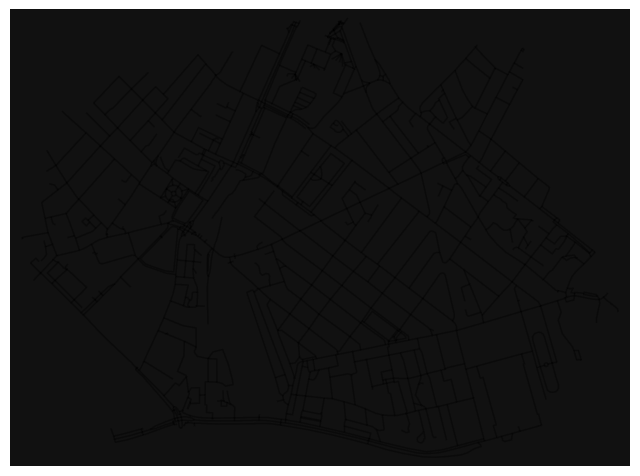

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

In [5]:
iso_colors = osmnx.plot.get_colors(n=5, cmap='Reds', start=0.3, return_hex=True)
isochrone_polys = make_iso_polys(test_map)

fig, ax = osmnx.plot_graph(test_map.graph, edge_color='k', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc='k', ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

# plt.show()

In [ ]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []

    trip_times = 
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = .ego_graph(G, center_ndde, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # If desired, try and "fill in" surrounded
        # areas so that shapes will appear solid and blocks
        # won't have white space inside of them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

# compare runtime for travel time calculation

In [ ]:
%%timeit

travel_times_for = {}
for route in test_routes:

    travel_time = 0
    for i in range(len(route)-1):

        edge = test_map.graph.get_edge_data(route[i], route[i+1])[0]
        travel_time += edge["travel_time"]

    travel_times_for[route[-1]] = travel_time

In [ ]:
%%timeit

paths = [osmnx.routing.route_to_gdf(test_map.graph, route, weight="travel_time") for route in test_routes]
travel_times_summed = [path['travel_time'].sum() for path in paths]
travel_times_gdf = {route[-1] : travel_time for route, travel_time in zip(test_routes, travel_times_summed)}


In [ ]:
# compare 

for key in travel_times_gdf.keys():
    print(key, travel_times_gdf[key], travel_times_for[key])